In [19]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(ch:pa_cleaning_aqs)=
# Wrangling and Cleaning AQS Sensor Data

Now that we have located sensors that are near each other, we are ready to wrangle and clean the files that contain the measurement data for these sites. We demonstrate the tasks involved with one AQS instrument and its matching PurpleAir sensor. We picked a pair located in Sacramento, California. The AQS sensor ID is
`06-067-0010`, and the PurpleAir sensor name is `AMTS_TESTINGA`.

The AQS provides a website and [API](https://aqs.epa.gov/aqsweb/documents/data_api.html) to download sensor data.
We downloaded the daily measurements from May 20, 2018, to December 29, 2019, into the
_data/aqs_06-067-0010.csv_ file. Let's begin by loading this file into a dataframe:

In [20]:
aqs_full = pd.read_csv('data/aqs_06-067-0010.csv')
aqs_full.shape

(2268, 31)

From the [data dictionary](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_hourly_data_files), we find out that the
column called `arithmetic_mean` corresponds to the actual PM2.5 measurements. Some AQS
sensors take a measurement every hour. 
For our analysis, we downloaded the 24-hour averages (the arithmetic mean) of the
hourly sensor measurements.

Let's carry out some quality checks and clean the data where necessary.
We focus on checks related to scope and quality of values: 

1. Check and correct the granularity of the data.
1. Remove unneeded columns.
1. Check values in the `date_local` column.
1. Check values in the `arithmetic_mean` column.

For the sake of brevity, we've chosen a few important quality checks that
specifically reinforce ideas we've covered in data wrangling, EDA, and visualization.

## Checking Granularity

We would like each row of our data to correspond to a single date with an average
PM2.5 reading for that date. As we saw earlier, a simple way to check is to see whether there are repeat values in the `date_local` column:

In [21]:
aqs_full['date_local'].value_counts()

date_local
2019-01-03    12
2018-12-31    12
2018-12-28    12
              ..
2018-11-28    12
2018-11-25    12
2018-11-22    12
Name: count, Length: 189, dtype: int64

Indeed, there are 12 rows for each date, so the granularity is *not* at the individual date level. 

From the data dictionary, we learn that there are multiple standards for
computing the final measurements from the raw sensor data.
The `pollutant_standard` column contains the name of each standard.
The `event_type` column marks whether data measured during "exceptional events"
are included in the measurement.
Let's check how different these average values are by calculating the range of 12 measurements:

In [22]:
(aqs_full
 .groupby('date_local')
 ['arithmetic_mean']
 .agg(np.ptp) # np.ptp computes max() - min()
 .value_counts()
)

arithmetic_mean
0.0    189
Name: count, dtype: int64

For all 189 dates, the max PM2.5 - min PM2.5 is 0. This means that we can simply take the first PM2.5 measurement for each date:

In [23]:
def rollup_dates(df):
    return (
        df.groupby('date_local')
        .first()
        .reset_index()
    )

In [24]:
aqs = (aqs_full
       .pipe(rollup_dates))
aqs.shape

(189, 31)

This data-cleaning step gives us the desired granularity:
each row represents a single date, with an average PM2.5 measurement for that date.
Next, we further modify the structure of the dataframe and drop unneeded columns. 

## Removing Unneeded Columns

We plan to match the PM2.5 measurements in the AQS dataframe with
the PurpleAir PM2.5 measurements for each date.
To simplify the structure, we can drop all but the date and PM2.5 columns.
We also rename the PM2.5 column so that it's easier to understand:

In [25]:
def drop_cols(df):
    subset = df[['date_local', 'arithmetic_mean']]
    return subset.rename(columns={'arithmetic_mean': 'pm25'})

In [26]:
aqs = (aqs_full
       .pipe(rollup_dates)
       .pipe(drop_cols))
aqs.head()

,date_local,pm25
0,2018-05-20,6.5
1,2018-05-23,2.3
2,2018-05-29,11.8
3,2018-06-01,6.0
4,2018-06-04,8.0


Now that we have the desired shape for our data table, we turn to checking the data values.

## Checking the Validity of Dates

Let's take a closer look at the dates.
We have already seen that there are gaps when there are no PM2.5 readings, so we expect there are missing dates.
Let's parse the dates as timestamp objects to make it easier to figure out which dates are missing.
As  we did in {numref}`Chapter %s <ch:wrangling>`, we check the format: 

In [27]:
aqs['date_local'].iloc[:3]

0    2018-05-20
1    2018-05-23
2    2018-05-29
Name: date_local, dtype: object

The dates are represented as YYYY-MM-DD, so we describe the format in the Python representation `'%Y-%m-%d'`.
To parse the dates, we use the `pd.to_datetime()` function, and we reassign the `date_local` column as `pd.TimeStamp`s:

In [28]:
def parse_dates(df):
    date_format = '%Y-%m-%d'
    timestamps = pd.to_datetime(df['date_local'], format=date_format)
    return df.assign(date_local=timestamps)

In [29]:
aqs = (aqs_full
       .pipe(rollup_dates)
       .pipe(drop_cols)
       .pipe(parse_dates))

The method runs without erroring, indicating that all the strings matched the format.

:::{note}

Just because the dates can be parsed doesn't mean that the dates are immediately
ready to use for further analysis. For instance, the string `9999-01-31` can be
parsed into a `pd.TimeStamp`, but the date isn't valid.

:::

Now that the dates have been converted to timestamps, we can calculate how
many dates are missing. We find the number of days between the earliest and
latest dates---this corresponds to the maximum number of measurements we could
have recorded:

In [30]:
date_range = aqs['date_local'].max() - aqs['date_local'].min()
date_range.days

588

Subtracting timestamps gives `Timedelta` objects, which as we see have a few useful properties.
There are many dates missing from the data. However, when we combine these
data for this sensor with other sensors, we expect to have enough data to fit a model.

Our final wrangling step is to check the quality of the PM2.5 measurements.

## Checking the Quality of PM2.5 Measurements

Particulate matter is measured in micrograms per cubic meter of air (µg/m<sup>3</sup>). (There are 1 million micrograms in 1 gram, and 1 pound is equal to about 450 grams.) The [EPA has set a standard](https://www.epa.gov/naaqs/particulate-matter-pm-air-quality-standards) of 35 µg/m<sup>3</sup> for a daily average of  PM2.5 and 12 µg/m<sup>3</sup>  for an annual average. 
We can use this information to make a few basic checks on the PM2.5 measurements.
First, PM2.5 can't go below 0. Second, we can look for abnormally high PM2.5 values and see whether they correspond to major events like a wildfire.

One visual way to perform these checks is to plot the PM2.5 measurement against the date:

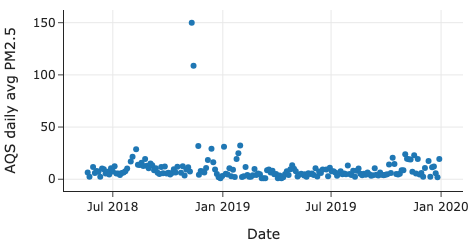

In [32]:
px.scatter(aqs, x='date_local', y='pm25',
           labels={'date_local':'Date', 'pm25':'AQS daily avg PM2.5'},
           width=500, height=250)

We see that the PM2.5 measurements don't go below 0 and are typically lower than the EPA level. We also found a large spike in PM2.5 around mid-November of 2018. This sensor is located in Sacramento, so we can check if there was a fire around that area.

Indeed, November 8, 2018, marks the start of the Camp Fire, the "deadliest and
most destructive wildfire in California history" (see the [Camp Fire page](https://www.census.gov/topics/preparedness/events/wildfires/camp.html) managed by the US Census Bureau).
The fire started just 80 miles north of Sacramento, so this AQS sensor captured the dramatic spike in PM2.5.

We've cleaned and explored the data for one AQS sensor.
In the next section, we do the same for its collocated PurpleAir sensor.